<a href="https://colab.research.google.com/github/killianraes/Machine_Learning_course_UGent_D012554_kaggle/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd


In [0]:
pip install git+git://github.com/rasbt/mlxtend.git

In [0]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")

testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

sample_submission = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/sample_submission.csv")

In [0]:
#Make copy's of data, in case something goes wrong
data_train = trainset.copy()
data_test = testset.copy()

Scaling of the training and test data

In [4]:
from sklearn.preprocessing import StandardScaler

X_train = data_train.copy()
y_train = X_train.pop('label')

feature_scaler = StandardScaler()
feature_scaler.fit(X_train)

X_train = pd.DataFrame(feature_scaler.transform(X_train))
X_train.columns = data_train.columns[:-1]

X_train.head()


,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
0,-0.018351,-0.396476,0.677912,-0.277047,0.733699,0.167400,1.330668,0.454721,0.093570,-0.068336,0.418469,0.026714,-0.156365,0.252992
1,0.052070,-0.791842,-0.136210,0.346482,-0.434286,-0.259658,0.007585,-1.609301,-0.482085,-0.276922,-0.232997,0.235973,0.060820,-0.037576
2,0.574178,0.222036,0.061066,-0.002733,-0.496011,-0.373355,0.031954,-0.716795,-0.482085,-0.381214,-1.894254,0.392280,0.091976,0.322059
3,2.972354,3.177226,5.588146,5.335202,6.480134,7.221060,4.638614,6.311759,6.199439,6.193291,4.834001,5.588622,3.349453,2.812530
4,1.293521,-1.135609,0.135164,-0.975478,-0.496011,-0.117120,1.208346,-0.131037,0.554655,0.505527,1.911632,1.776139,1.782573,1.401236


In [5]:
X_test = data_test.copy()
index = X_test.pop('index')

X_test = pd.DataFrame(feature_scaler.transform(X_test))
X_test.columns = data_test.columns[:-1]

X_test.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
0,-0.103077,1.046608,-0.506702,0.072168,-0.004007,-0.088835,0.154276,-0.772271,-0.971812,-1.346811,-0.169859,-0.495161,-0.202948,-0.466549
1,-0.244195,-0.499673,-0.802616,-0.975478,-0.802839,-0.202532,-0.702932,0.398702,-0.136692,-0.146683,-0.443319,-0.913170,-0.358124,-0.590924
2,-0.018351,0.342321,0.282880,-0.301852,0.149407,0.849583,-0.237536,0.649974,0.583297,0.140249,0.040053,0.105122,-0.249531,-0.258808
3,-0.554489,-0.155906,-0.013033,-0.102439,-1.079704,-0.941841,-1.511881,-1.414048,-1.461540,-0.903186,-0.359272,-0.338853,0.107403,-0.425001
4,0.475423,-1.358756,-0.161230,-1.025087,-0.004007,-1.084378,-0.041630,-0.410047,-0.539931,0.035956,-0.085812,0.183531,-0.388978,0.349848


# Support vector machines

Support vector machines allow us to predict the class of a certain sample based on the parameters of the sample. Tho achieve this, a model is trained that separates the classes linearly based on their feature values. This is shown in the plot below where the orange points represent class 1 and the blue points class 0. The x- and y-axis show two features. This plot shows that the classes are linearly separable by multiple lines.

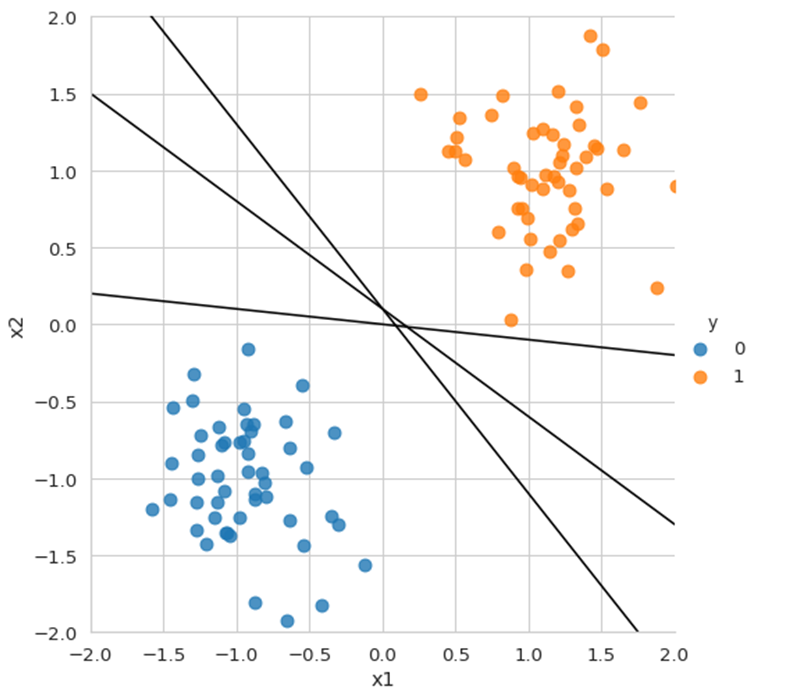

In order to find the best separator, a cost function is assigned which the model tries to keep as low as possible. The plot below represents the cost function with the orange line representing class 1 and the blue line class 0. On the x-axis the prediction of our model is represented and on the y-axis the attribution of a prediction to the cost function.

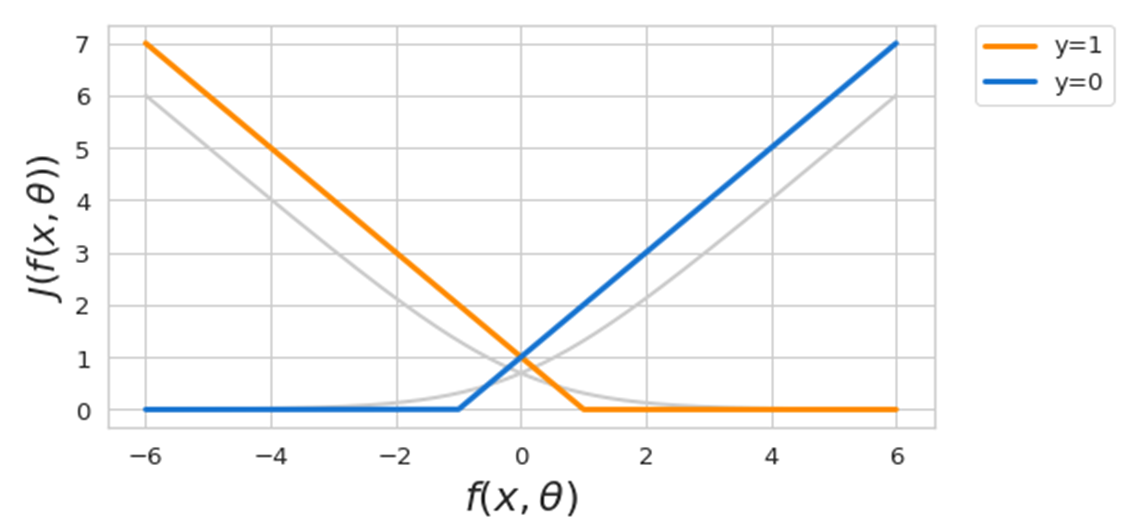

When the model predicts correctly there is no attribution to the cost function. This is also the case when the model 'overshoots' the actual value (e.g. when the actual value is 1 and the model predicts 1 or higher, or whent the actual value is -1 and the model predicts -1 or lower). Furthermore, we can see that the attribution to the cost function increases linearly in function of the misprediction. This means that when the actual value is 1 and the model predicts e.g. 0.5 that this will result in an attribution to the cost function and that this cost will increase linearly the lower the prediction is. The same happens for an actual value of -1 and a prediction higher than one.

By minimizing the cost function, the optimal separation between classes can be calculated

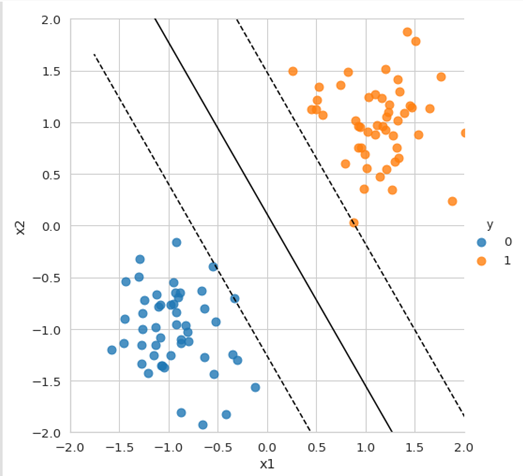


If we would now present the model with an unseen sample (e.g. x=1.0, y=1.5), the model would be able to assign a class (class 1) to this sample based on the previously seen data

# Support vector machines

First, I tried to compare a range of machine learning algorithms in their basic version.

>dec_tr 0.743 (0.028)
>log_re 0.655 (0.021)
>SVM 0.886 (0.013)
>nai_ba 0.668 (0.030)
>K_nei 0.932 (0.010)
>Ran_for 0.921 (0.022)
>XGB 0.873 (0.020)


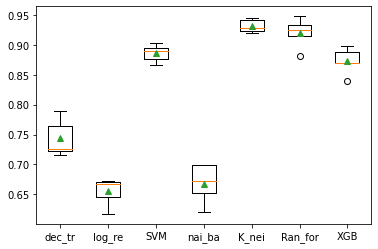

In [28]:
#support vector machines
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from mlxtend.classifier import StackingClassifier

models = dict()
models['dec_tr'] = DecisionTreeClassifier()
models['log_re'] = LogisticRegression()
models['SVM'] = SVC()
models['nai_ba'] = GaussianNB()
models['K_nei'] = KNeighborsClassifier()
models['Ran_for'] = RandomForestClassifier()
models['XGB'] = XGBClassifier()

results = list()
names = list()
for name, model in models.items():
  scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc')
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' %(name, np.mean(scores), np.std(scores)))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

This plot shows the results of the algorithm comparisson. We can see that the bast basemodel is K-nearest neighbors (0.932) colosely followed by random forests (0.921). We also see that SVM performs decently, but is heavily outperformed by the two previously mentioned algorithms mentioned before.

Next, i used gridsearchcv to optimise the hyperparameters gamma and C. C is a regularisation parameter that regulates the complexity of the model. The higher this value, the more complex the model will be. This parameter is required to prevent overfitting (the model might become so complex that it fits the training data perfectly while it performs bad on the test data). Gamma has somewhat the same effect. The higher gamma becomes, the more the model tries to find the perfect fit for the data it has been fed, possibly leading to overfitting. Thus, it is important to find the optimal value for both these parameters which leads to the perfect tradeoff between model complexity and overfitting.

In [7]:
##Support vector machine
from sklearn.model_selection import GridSearchCV
model = SVC(random_state=0)
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma = ['scale', 'auto', 0.00001, 0.0001, 0.001, 0.01, 0.1]
params = {'C': C,
          'gamma': gamma}

clf = GridSearchCV(model, param_grid=params, cv=5)
best_params = clf.fit(X_train, y_train)

print('Best C:', best_params.best_estimator_.get_params()['C'])
print('Best gamma:', best_params.best_estimator_.get_params()['gamma'])

Best C: 100
Best gamma: 0.1


As you can see, a C-value of 100 and a gamma of 0.1 should prove to be optimal for our dataset. In order to confirm this the auc-score was calculated for the optimised SVM-model and compared to the same models it had previously been compared to. Important to note is that all of these models had been optimised as well, using GridSearch.

>dec_tr 0.754 (0.015)
>log_re 0.655 (0.022)
>SVM 0.956 (0.016)
>nai_ba 0.668 (0.030)
>K_nei 0.935 (0.016)
>Ran_for 0.907 (0.020)
>XGB 0.914 (0.015)


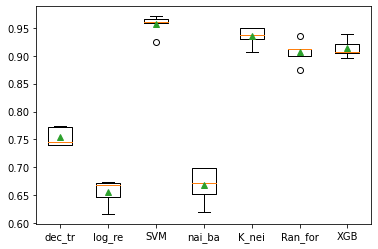

In [27]:
models = dict()
models['dec_tr'] = DecisionTreeClassifier(max_depth=25, 
                                          max_features=10, 
                                          random_state=0)
models['log_re'] = LogisticRegression(C = 0.5, 
                                      random_state=0)
models['SVM'] = SVC(C = 100,
                    gamma=0.1, 
                    random_state=0)
models['nai_ba'] = GaussianNB()
models['K_nei'] = KNeighborsClassifier(n_neighbors=2, 
                                       weights='distance', 
                                       algorithm='ball_tree',
                                       p=2)
models['Ran_for'] = RandomForestClassifier(bootstrap= True,
                                           max_depth= 80,
                                           max_features= 'auto',
                                           min_samples_leaf= 3,
                                           min_samples_split= 8,
                                           n_estimators= 100,
                                           random_state=0)
models['XGB'] = XGBClassifier(learning_rate = 0.2, 
                                     n_estimators=100, 
                                     objective='binary:logistic', 
                                     max_depth=5, 
                                     min_child_weight=3, 
                                     max_delta_step=1, 
                                     subsample=0.8, 
                                     random_state=0)

results = list()
names = list()
for name, model in models.items():
  scores = cross_val_score(model, X_train, y_train, scoring='roc_auc')
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' %(name, np.mean(scores), np.std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Here we can clearly see that the SVM-model (0.956) now outperforms all competitors with the closest persuer being K-nearest neighbors (0.935). Remarkable is that the score for the K-nearest neighbors algorithm did not change and that the score for the random forest actually decreased with optimisation. This leads to believe that misstakes were made during the optimisation of the random forest algoritm which is a potential explanation for why the model maxed out at 0.97401 in the competition.

# Stacking

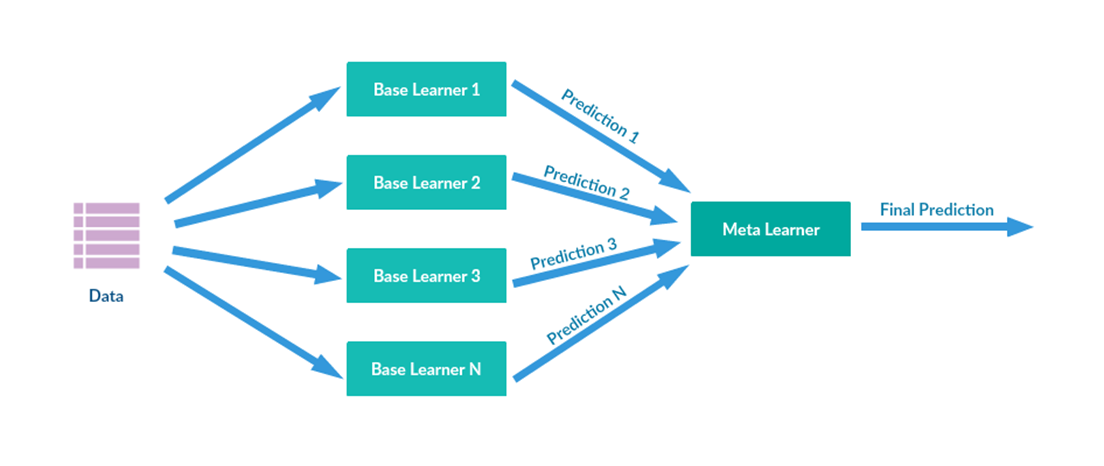

In stacking, the data is used to train base learners, which then make predictions based on the features of the training data. These predictions are then used to train the meta-learner which will make the final predictions.

In [26]:
models = dict()
models['dec_tr'] = DecisionTreeClassifier(max_depth=25, 
                                          max_features=10, 
                                          random_state=0)
models['log_re'] = LogisticRegression(C = 0.5, 
                                      random_state=0)
models['SVM'] = SVC(C = 100,
                    gamma=0.1, 
                    random_state=0)
models['nai_ba'] = GaussianNB()
models['K_nei'] = KNeighborsClassifier(n_neighbors=2, 
                                       weights='distance', 
                                       algorithm='ball_tree',
                                       p=2)
models['ran_for'] = RandomForestClassifier(bootstrap= True,
                                           max_depth= 80,
                                           max_features= 'auto',
                                           min_samples_leaf= 3,
                                           min_samples_split= 8,
                                           n_estimators= 100,
                                           random_state=0)
models['XGB'] = XGBClassifier(learning_rate = 0.2, 
                                     n_estimators=100, 
                                     objective='binary:logistic', 
                                     max_depth=5, 
                                     min_child_weight=3, 
                                     max_delta_step=1, 
                                     subsample=0.8, 
                                     random_state=0)
predictions = pd.DataFrame()
predictions['label'] = y_train
for name,model in models.items():
  model.fit(X_train, y_train)
  predictions[name] = model.predict(X_train)

predictions.head()

,label,dec_tr,log_re,SVM,nai_ba,K_nei,ran_for,XGB
0,1,1,1,1,1,1,1,1
1,0,0,1,0,1,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0
4,1,1,1,1,1,1,1,1


>dec_tr 0.754 (0.015)
>log_re 0.655 (0.022)
>SVM 0.956 (0.016)
>nai_ba 0.668 (0.030)
>K_nei 0.935 (0.016)
>Ran_for 0.907 (0.020)
>XGB 0.914 (0.015)
>stack 0.950 (0.014)


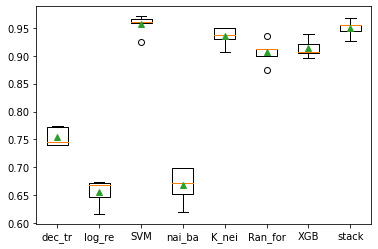

In [19]:
models = dict()
models['dec_tr'] = DecisionTreeClassifier(max_depth=25, 
                                          max_features=10, 
                                          random_state=0)
models['log_re'] = LogisticRegression(C = 0.5, 
                                      random_state=0)
models['SVM'] = SVC(C = 100,
                    gamma=0.1, 
                    random_state=0)
models['nai_ba'] = GaussianNB()
models['K_nei'] = KNeighborsClassifier(n_neighbors=2, 
                                       weights='distance', 
                                       algorithm='ball_tree',
                                       p=2)
models['Ran_for'] = RandomForestClassifier(bootstrap= True,
                                           max_depth= 80,
                                           max_features= 'auto',
                                           min_samples_leaf= 3,
                                           min_samples_split= 8,
                                           n_estimators= 100,
                                           random_state=0)
models['XGB'] = XGBClassifier(learning_rate = 0.2, 
                                     n_estimators=100, 
                                     objective='binary:logistic', 
                                     max_depth=5, 
                                     min_child_weight=3, 
                                     max_delta_step=1, 
                                     subsample=0.8, 
                                     random_state=0)

level_0 = list()
level_0.append(KNeighborsClassifier(n_neighbors=2,
                                    weights='distance',
                                    algorithm='ball_tree',
                                    p=2))
level_0.append(DecisionTreeClassifier(max_depth=25, 
                                      max_features=10, 
                                      random_state=0))
level_0.append(SVC(C = 100, gamma=0.1, random_state=0, probability=True))
level_0.append(RandomForestClassifier(bootstrap= True,
                                      max_depth= 80,
                                      max_features= 'auto',
                                      min_samples_leaf= 3,
                                      min_samples_split= 8,
                                      n_estimators= 100,
                                      random_state=0))
level_0.append(XGBClassifier(learning_rate = 0.2, 
                             n_estimators=100, 
                             objective='binary:logistic', 
                             max_depth=5, 
                             min_child_weight=3,
                             max_delta_step=1, 
                             subsample=0.8, 
                             random_state=0))
level_0.append(LogisticRegression(C = 0.5, 
                                  random_state=0))
level_0.append(GaussianNB())
level_1 = LogisticRegression(random_state=0)

models['stack'] = StackingClassifier(classifiers= level_0, meta_classifier= level_1, use_probas=True)

results = list()
names = list()
for name, model in models.items():
  scores = cross_val_score(model, X_train, y_train, scoring='roc_auc')
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' %(name, np.mean(scores), np.std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [0]:
model = SVC(C = 100, gamma=0.1, random_state=0, probability=True)
model.fit(X_train, y_train)
predictions = pd.DataFrame(model.predict_proba(X_test))
predictions.columns=['0', '1']
SVC_pred = pd.DataFrame()
SVC_pred['index'] = index
SVC_pred['label'] = predictions['1']

In [12]:
level_0 = list()
level_0.append(('K_nei', KNeighborsClassifier(n_neighbors=2, 
                                              weights='distance', 
                                              algorithm='ball_tree',
                                              p=2)))
level_0.append(('dec_tr', DecisionTreeClassifier(max_depth=25, 
                                                 max_features=10, 
                                                 random_state=0)))
level_0.append(('SVM', SVC(C = 100, gamma=0.1, random_state=0)))
level_0.append(('Ran_fr', RandomForestClassifier(bootstrap= True,
                                                 max_depth= 80,
                                                 max_features= 'auto',
                                                 min_samples_leaf= 3,
                                                 min_samples_split= 8,
                                                 n_estimators= 100,
                                                 random_state=0)))
level_0.append(('XGB', XGBClassifier(learning_rate = 0.2, 
                                     n_estimators=100, 
                                     objective='binary:logistic', 
                                     max_depth=5, 
                                     min_child_weight=3, 
                                     max_delta_step=1, 
                                     subsample=0.8, 
                                     random_state=0)))
level_0.append(('log_re', LogisticRegression(C = 0.5, 
                                             random_state=0)))
level_0.append(('nai_ba', GaussianNB()))
level_1 = LogisticRegression(random_state=0)

model = StackingClassifier(classifiers= level_0, meta_classifier= level_1)
model.fit(X_train, y_train)
predictions = pd.DataFrame(model.predict_proba(X_test))
predictions.columns=['0', '1']
stack_pred = pd.DataFrame()
stack_pred['index'] = index
stack_pred['label'] = predictions['1']

TypeError: ignored